In [256]:
import yfinance as yf
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import copy 
import random 

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [257]:
tickers = [
    # Mega-cap Tech (keep for comparison)
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA",
    # Financials
    "JPM", "BAC", "GS", "C", 
    # Healthcare
    "JNJ", "PFE", "MRK", "UNH", 
    # Energy
    "XOM", "CVX", "COP", "SLB",
    # Industrials / Consumer
    "BA", "CAT", "MMM", "DIS", "NKE",    
]

def fetch_stock_data(tickers, start_date="2008-01-01", end_date="2025-10-01"): 
    return yf.download(tickers, start=start_date, end=end_date) 

yfinance_df  = fetch_stock_data(tickers).dropna(how='any',axis=1).dropna(how='any',axis=0)


/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_49365/2975323493.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  22 of 22 completed


In [258]:
# Get Monday open and Friday close within each week
weekly_open = yfinance_df["Open"].resample("W-FRI").first()
weekly_close = yfinance_df["Close"].resample("W-FRI").last()

# Compute weekly return: Monday open → Friday close
y = (weekly_close / weekly_open - 1).shift(-1).dropna()

# Weekly features (Friday snapshot)
X = yfinance_df.resample("W-FRI").last().dropna()

tickers = ['IEF', 'TLT', 'SHY', 'GLD', 'USO', '^VIX', 'DX-Y.NYB']  # DXY ticker on Yahoo
macro_data = yf.download(tickers, start='2010-01-01', end='2025-10-31')['Close']
macro_weekly = macro_data.resample("W-FRI").last().dropna()
X = pd.concat([X, macro_weekly], axis=1).dropna()

# Align features and target
common = X.index.intersection(y.index)
X = X.loc[common]
y = y.loc[common]

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size-1)*dilation, dilation=dilation
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act1 = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        # x: (batch, channels, seq_len)
        out = self.conv1(x)
        out = out[:, :, :x.size(2)]  # crop to original seq_len
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout(out)
        res = self.residual(x)
        return out + res

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        # ensure y is always 2D: (num_samples, n_outputs)
        if self.y.ndim == 1:
            self.y = self.y[:, None]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_dollar_neutral(x):
    # x: (batch, n_outputs)
    return x - x.mean(dim=1, keepdim=True)

class CNNLSTM2D(nn.Module):
    def __init__(self, n_features, n_outputs, lookback):
        super().__init__()
        # Convolution along features only, per time step
        self.conv = nn.Conv2d(
            in_channels=1,       # single “channel” per sample
            out_channels=16,     # number of feature maps
            kernel_size=(1, 5),  # kernel spans features, not time
            padding=(0, 2)       # pad only along features
        )
        self.bn = nn.BatchNorm2d(16)
        self.act = nn.GELU()

        # LSTM along time dimension
        self.lstm = nn.LSTM(
            input_size=n_features + 16,  # original features + conv channels
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            dropout=0.1
        )
        self.fc = nn.Linear(64, n_outputs)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        B, T, F = x.shape

        # Conv2d expects (B, C, H, W) → here H=1, W=features
        x_in = x.unsqueeze(1)  # (B, 1, T, F)
        x_cnn = self.act(self.bn(self.conv(x_in)))  # (B, 16, T, F)
        # Pool along features (optional)
        x_cnn = x_cnn.mean(dim=-1)  # (B, 16, T)

        # Prepare for LSTM: concat conv features with original
        x_cnn = x_cnn.permute(0, 2, 1)          # (B, T, 16)
        x_combined = torch.cat([x, x_cnn], dim=-1)  # (B, T, F+16)

        # LSTM along time
        x_lstm, _ = self.lstm(x_combined)
        x_out = self.dropout(x_lstm[:, -1, :])
        x_out = self.fc(x_out)

        x_out = make_dollar_neutral(x_out)  # ensure dollar-neutral outputs
        return x_out

class MLP(nn.Module):
    def __init__(self, n_features, n_outputs, lookback):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features * lookback, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # x: (batch, seq_len, n_features)
        x = x.reshape(x.size(0), -1)  # flatten, works even if not contiguous
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = make_dollar_neutral(x)  # ensure dollar-neutral outputs
        return x
    
class LSTMModel(nn.Module):
    def __init__(self, n_features, n_outputs, lookback):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, n_outputs)   # map to number of assets
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])      # last LSTM output
        x = self.relu(self.fc1(x))
        x = self.fc2(x)                     # now shape = (batch_size, n_outputs)
        x = make_dollar_neutral(x)          # ensure dollar-neutral outputs
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Dataset class -----
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# ----- Sharpe Loss with Transaction Cost -----
class SharpeLossWithTC(nn.Module):
    def __init__(self, tc_lambda=0.001, eps=1e-4):
        super().__init__()
        self.tc_lambda = tc_lambda
        self.eps = eps

    def forward(self, y_pred, y_true, prev_weights=None):
        weights = y_pred
        # Portfolio returns
        port_returns = torch.sum(weights * y_true, dim=1)
        mean = torch.mean(port_returns)
        std = torch.std(port_returns, unbiased=False) + self.eps  # avoids warning
        sharpe = mean / std

        # Transaction cost penalty
        t_cost = 0.005
        if prev_weights is not None:
            # prev_weights may have different batch sizes; slice to match current batch
            if prev_weights.shape[0] != weights.shape[0]:
                prev_weights = prev_weights[-weights.shape[0]:, :]
            t_cost = torch.mean(torch.abs(weights - prev_weights))

        return -sharpe + self.tc_lambda * t_cost, weights

# --- Helper: Train model on a rolling window with optional verbosity, early stopping on loss ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, verbose=False):
    best_val_loss = np.inf
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        prev_w = None
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss, prev_w = criterion(y_pred, y_batch, prev_weights=prev_w)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            prev_w = prev_w.detach()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- Validation ---
        model.eval()
        prev_w_val = None
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss, prev_w_val = criterion(y_pred, y_batch, prev_weights=prev_w_val)
                prev_w_val = prev_w_val.detach()
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # --- Early stopping on validation loss ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
                break

        # --- Verbose printing ---
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return best_model_state

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(torch.tensor(X[i:i+lookback], dtype=torch.float32))
        y_seq.append(torch.tensor(y[i:i+lookback][-1], dtype=torch.float32))  # last y in window
    return torch.stack(X_seq), torch.stack(y_seq)

lookback = int(126//5)  # 6 months
training_window = int(252*5//5)  # 3 years
val_window = int(252//5)         # 1 year
ensemble_size = 5          # number of model initializations per retraining

models_to_run = {
    "MLP": MLP,
    "LSTM": LSTMModel,
    "CNNLSTM": CNNLSTM2D    
}

results = {}

for name, ModelClass in models_to_run.items():
    print(f"\n=== Training {name} (Ensemble of {ensemble_size}) ===")
    criterion = SharpeLossWithTC(tc_lambda=0.1)

    oos_returns = []
    oos_weights = []
    oos_dates = []

    start_train = training_window + val_window
    all_test_days = X.index[start_train:]

    # --- First day of each month for retraining ---
    all_test_days_series = all_test_days.to_series()
    yearly_train_days = (
        all_test_days_series.groupby(all_test_days_series.dt.to_period("Y")).first()
    )
    yearly_train_days.index = yearly_train_days.index.to_timestamp()

    # drop any NAs (in case a year has no test days)
    yearly_train_days = yearly_train_days.dropna()
    
    for idx, year_start in enumerate(yearly_train_days):
        print(f"\nRetraining {name} for year starting {year_start}")
        t = X.index.get_loc(year_start)

        next_year_idx = (
            X.index.get_loc(yearly_train_days[idx + 1])
            if idx + 1 < len(yearly_train_days)
            else len(X)
        )

        # --- Rolling window for train/val ---
        train_start = t - training_window - val_window
        train_end   = t - val_window
        val_start   = train_end
        val_end     = t

        X_train_window = X.iloc[train_start:train_end].values
        y_train_window = y.iloc[train_start:train_end].values
        X_val_window   = X.iloc[val_start:val_end].values
        y_val_window   = y.iloc[val_start:val_end].values

        # --- Normalize once ---
        X_mean = X_train_window.mean(axis=0)
        X_std  = X_train_window.std(axis=0) + 1e-8
        X_train_norm = (X_train_window - X_mean) / X_std
        X_val_norm   = (X_val_window - X_mean) / X_std

        # --- Create sequences ---
        X_train_seq, y_train_seq = create_sequences(X_train_norm, y_train_window, lookback)
        X_val_seq, y_val_seq     = create_sequences(X_val_norm, y_val_window, lookback)

        train_loader = DataLoader(
            TimeSeriesDataset(X_train_seq, y_train_seq),
            batch_size=64,
            shuffle=True,
            num_workers=0,
            generator=torch.Generator().manual_seed(seed)
        )

        val_loader = DataLoader(
            TimeSeriesDataset(X_val_seq, y_val_seq),
            batch_size=64,
            shuffle=False,
            num_workers=0,
            generator=torch.Generator().manual_seed(seed)
        )

        # --- Train ensemble models ---
        ensemble_models = []
        for seed in range(ensemble_size):
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            
            model = ModelClass(n_features=X.shape[1], n_outputs=y.shape[1], lookback=lookback).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            best_state = train_model(model, train_loader, val_loader, criterion, optimizer, verbose=False)
            model.load_state_dict(best_state)
            ensemble_models.append(model)

        for test_day in range(t, next_year_idx):
            if test_day - lookback + 1 < 0:
                continue
            X_test_seq = X.iloc[test_day - lookback + 1:test_day + 1].values
            X_test_norm = (X_test_seq - X_mean) / X_std
            X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(0).to(device)

            y_test_tensor = torch.tensor(y.iloc[test_day:test_day+1].values, dtype=torch.float32).to(device)

            # --- Ensemble prediction ---
            preds = []
            for model in ensemble_models:
                model.eval()
                with torch.no_grad():
                    preds.append(model(X_test_tensor))
            y_pred = torch.stack(preds).mean(dim=0)

            # --- Compute portfolio return ---
            weights = y_pred
            r = torch.sum(weights * y_test_tensor, dim=1)

            oos_returns.append(r.cpu().numpy())
            oos_weights.append(weights.cpu().numpy()[0])
            oos_dates.append(X.index[test_day])

    # --- Save out-of-sample results ---
    oos_weights_df = pd.DataFrame(oos_weights, index=oos_dates, columns=y.columns)
    oos_returns_series = pd.Series(np.concatenate(oos_returns), index=oos_dates, name="OOS_Returns")
    oos_weights_df.to_csv(f"{name}_oos_weights.csv")
    oos_returns_series.to_csv(f"{name}_oos_returns.csv")

    oos_returns_arr = np.concatenate(oos_returns)
    oos_sharpe = np.mean(oos_returns_arr) / (np.std(oos_returns_arr) + 1e-8) * np.sqrt(252)
    print(f"{name} Out-of-sample annualized Sharpe: {oos_sharpe:.3f}")

    results[name] = oos_sharpe

# --- Summary ---
print("\n=== Summary of Out-of-Sample Sharpe Ratios ===")
for name, sharpe in results.items():
    print(f"{name}: {sharpe:.3f}")


/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_49365/3675773632.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(tickers, start='2010-01-01', end='2025-10-31')['Close']
[*********************100%***********************]  7 of 7 completed
/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_49365/3675773632.py:289: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X.index.get_loc(yearly_train_days[idx + 1])



=== Training MLP (Ensemble of 5) ===

Retraining MLP for year starting 2015-10-23 00:00:00

Retraining MLP for year starting 2016-01-01 00:00:00

Retraining MLP for year starting 2017-01-06 00:00:00

Retraining MLP for year starting 2018-01-05 00:00:00

Retraining MLP for year starting 2019-01-04 00:00:00

Retraining MLP for year starting 2020-01-03 00:00:00

Retraining MLP for year starting 2021-01-01 00:00:00

Retraining MLP for year starting 2022-01-07 00:00:00

Retraining MLP for year starting 2023-01-06 00:00:00

Retraining MLP for year starting 2024-01-05 00:00:00

Retraining MLP for year starting 2025-01-03 00:00:00
MLP Out-of-sample annualized Sharpe: 1.111

=== Training LSTM (Ensemble of 5) ===

Retraining LSTM for year starting 2015-10-23 00:00:00

Retraining LSTM for year starting 2016-01-01 00:00:00

Retraining LSTM for year starting 2017-01-06 00:00:00

Retraining LSTM for year starting 2018-01-05 00:00:00

Retraining LSTM for year starting 2019-01-04 00:00:00

Retraining

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(



Retraining CNNLSTM for year starting 2016-01-01 00:00:00

Retraining CNNLSTM for year starting 2017-01-06 00:00:00

Retraining CNNLSTM for year starting 2018-01-05 00:00:00

Retraining CNNLSTM for year starting 2019-01-04 00:00:00

Retraining CNNLSTM for year starting 2020-01-03 00:00:00

Retraining CNNLSTM for year starting 2021-01-01 00:00:00

Retraining CNNLSTM for year starting 2022-01-07 00:00:00

Retraining CNNLSTM for year starting 2023-01-06 00:00:00

Retraining CNNLSTM for year starting 2024-01-05 00:00:00

Retraining CNNLSTM for year starting 2025-01-03 00:00:00
CNNLSTM Out-of-sample annualized Sharpe: 2.790

=== Summary of Out-of-Sample Sharpe Ratios ===
MLP: 1.111
LSTM: 0.169
CNNLSTM: 2.790


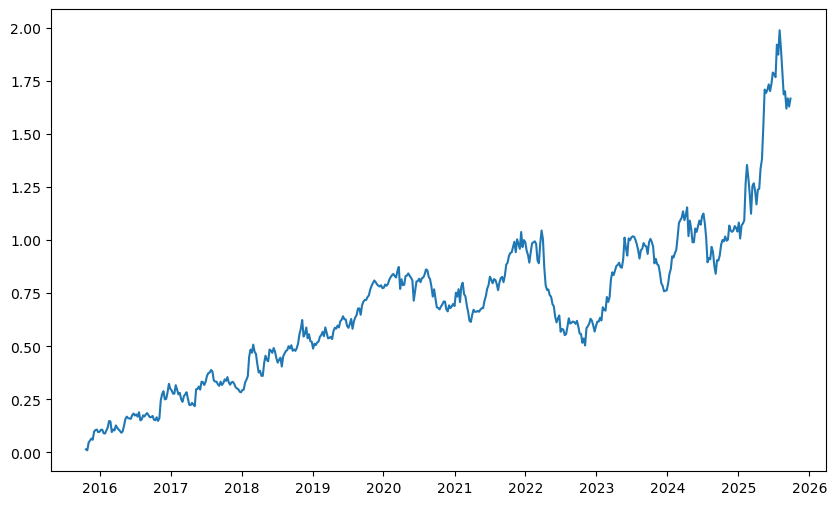

In [260]:
cnn_lstm_weights = pd.read_csv("CNNLSTM_oos_weights.csv", index_col=0, parse_dates=True)
returns = (yfinance_df["Close"].resample("W-FRI").last()- yfinance_df["Close"].resample("W-FRI").first()) / yfinance_df["Close"].resample("W-FRI").first()
portfolio_returns = (cnn_lstm_weights * returns.loc[cnn_lstm_weights.index]).sum(axis=1)s
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='CNN-LSTM Portfolio')